In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import clear_output
%matplotlib inline

In [2]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [3]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [4]:
sol = solve_ivp(FHN, [0, 200000], [-0.1, 0.1, -0.1, -0.1], 
                t_eval=np.array(range(0, 200000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

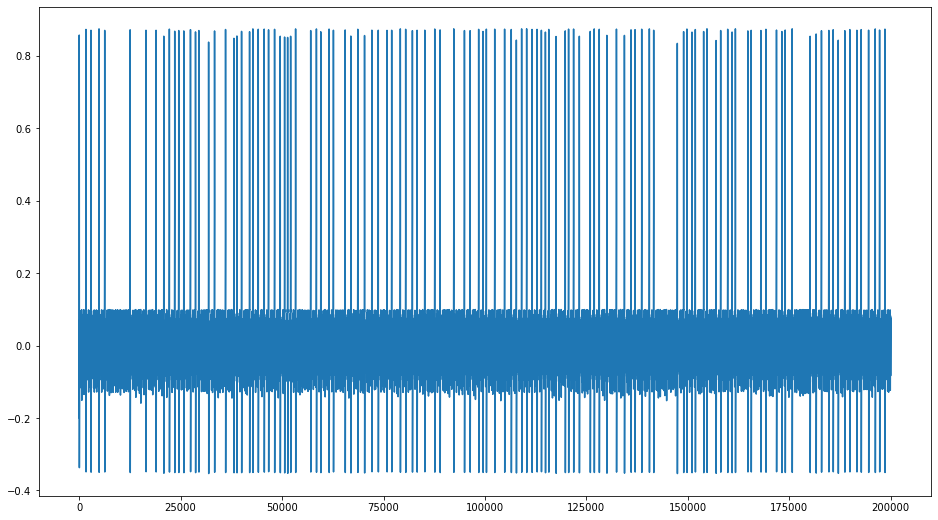

In [5]:
plt.figure(figsize=(16, 9))

plt.plot(sol.t, sol.y[0])

In [9]:
train = sol.y[0][:75000]
test =  sol.y[0][75000:]

mean = train.mean()
std = train.std()

train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [7]:
Hr = mean + 6*std

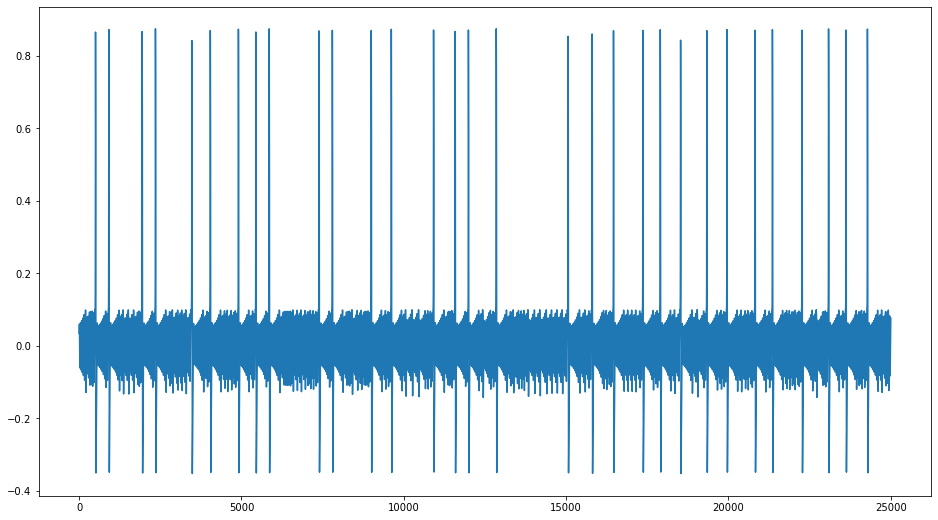

In [43]:
plt.figure(figsize=(16, 9))

plt.plot(test)

In [47]:
test[470:530]

array([ 0.00759952,  0.01704886,  0.02619194,  0.03498949,  0.04340121,
        0.05138543,  0.05889901,  0.06589771,  0.07233692,  0.0781728 ,
        0.08336405,  0.08787413,  0.09167419,  0.09474659,  0.09708905,
        0.09871928,  0.09968008,  0.10004474,  0.09992312,  0.09946878,
        0.09888923,  0.09846274,  0.0985691 ,  0.09974813,  0.10281326,
        0.10907493,  0.12079064,  0.14209579,  0.18093888,  0.25273721,
        0.38388118,  0.59107234,  0.78758115,  0.86318919,  0.86474317,
        0.84325013,  0.81411061,  0.78066798,  0.74297583,  0.69968962,
        0.64800972,  0.58247773,  0.49177056,  0.351522  ,  0.12330275,
       -0.14544127, -0.28374789, -0.33405603, -0.35089567, -0.34515359,
       -0.33241959, -0.31837904, -0.30421066, -0.2901291 , -0.2761734 ,
       -0.26235094, -0.24866338, -0.23511148, -0.2216961 , -0.20841848])

In [44]:
ee = []
normal = []
i = 40
while i < test.shape[0]:
    if (test[i] > Hr):
        ee.append(test[i-40: i-20])
        i += 30
    else:
        normal.append(test[i-40: i-20])
    i += 1

In [46]:
len(normal)

23999

In [45]:
len(ee)

31

In [15]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [10]:
from IPython.display import clear_output

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [12]:
from torch.utils.data import DataLoader

In [16]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [14]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

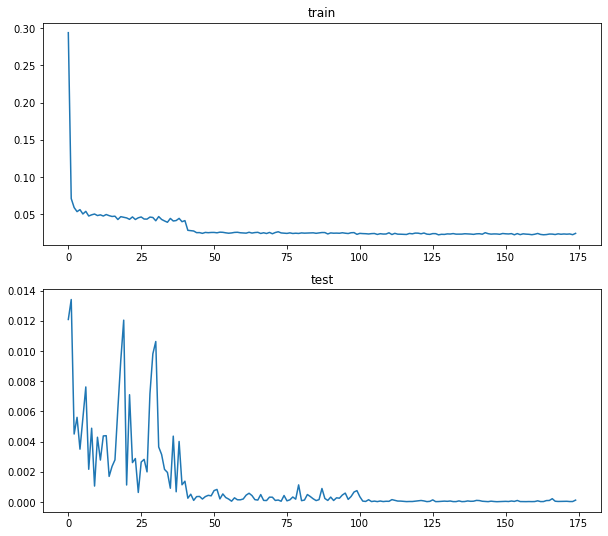

Epoch[175/175] | loss train:0.024490, test:0.000129


In [17]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

In [18]:
torch.save(model.state_dict(), 'FHNDeepModel')

In [20]:
test_inout_seq[0][0]

tensor([ 0.1663,  0.2189,  0.2665,  0.3079,  0.3422,  0.3679,  0.3836,  0.3871,
         0.3764,  0.3488,  0.3018,  0.2332,  0.1419,  0.0293, -0.0997, -0.2363,
        -0.3684, -0.4834, -0.5719, -0.6294])

In [ ]:
seq = test_inout_seq[0][0]
model.eval()
predicted = []
for i in range(len(test_norm)-20):
    x = torch.reshape(seq, (1, 20, 1)).to('cuda')
    out = model(x)
    predicted += out.detach().tolist()
    seq_list = seq.tolist()[1:]
    seq_list.append(out.detach().tolist()[0])
    seq = torch.tensor(seq_list)
  

In [25]:
model.eval()
model.to('cpu')
rmse = []

k = 20
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        x = torch.reshape(torch.FloatTensor(loop_steps).view(-1), (1, 20, 1))
        y_pred = model(x)
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

r = (((np.array(prediction[:-k+1])*std+mean - np.array(test[20+k-1:]))**2).mean())**0.5
r

0.3933992474174675

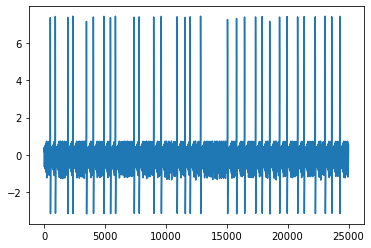

In [29]:
plt.plot(test_norm)

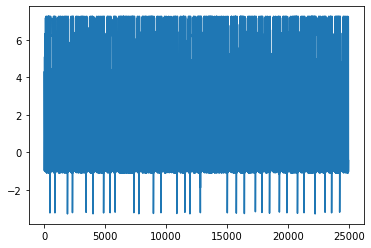

In [28]:
plt.plot(prediction)


In [78]:
model.eval()
model.to('cpu')
rmse = []

k = 10
last_k_step = test_norm[:k].tolist()
prediction_10 = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        x = torch.reshape(torch.FloatTensor(loop_steps).view(-1), (1, 20, 1)).to('cpu')
        y_pred = model(x)
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction_10.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

r = (((np.array(prediction_10[:-k+1])*std+mean - np.array(test[20+k-1:]))**2).mean())**0.5
r

0.08813340933057354

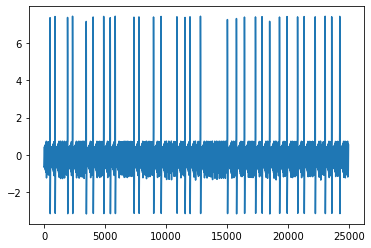

In [49]:
plt.plot(test_norm[20:])

In [57]:
len(prediction_10)

24980

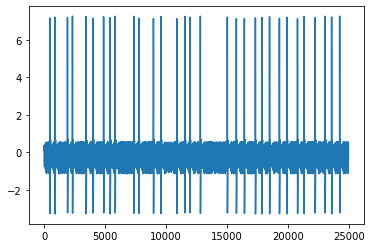

In [33]:
plt.plot(prediction)


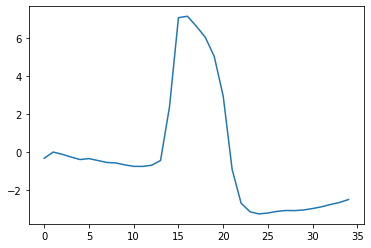

In [47]:
plt.plot(prediction_10[460:495])

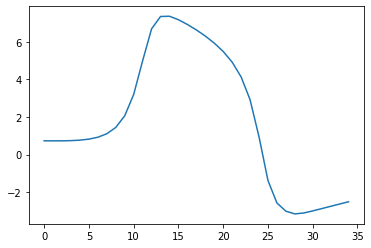

In [58]:
plt.plot(test_norm[490:525])

In [63]:
torch.tensor(prediction_10[460:495])

tensor([-3.2618e-01,  1.1093e-03, -1.1150e-01, -2.6045e-01, -3.9266e-01,
        -3.4283e-01, -4.4284e-01, -5.4626e-01, -5.7107e-01, -6.7127e-01,
        -7.5222e-01, -7.5478e-01, -6.9511e-01, -4.4295e-01,  2.3846e+00,
         7.0877e+00,  7.1655e+00,  6.6374e+00,  6.0550e+00,  5.0433e+00,
         2.9500e+00, -9.2010e-01, -2.6937e+00, -3.1502e+00, -3.2601e+00,
        -3.2106e+00, -3.1274e+00, -3.0800e+00, -3.0861e+00, -3.0510e+00,
        -2.9764e+00, -2.8822e+00, -2.7620e+00, -2.6547e+00, -2.5018e+00])

In [62]:
test_norm[490:525]

tensor([ 0.7317,  0.7280,  0.7290,  0.7392,  0.7658,  0.8201,  0.9217,  1.1064,
         1.4432,  2.0658,  3.2029,  4.9995,  6.7035,  7.3591,  7.3726,  7.1862,
         6.9335,  6.6435,  6.3167,  5.9414,  5.4932,  4.9250,  4.1385,  2.9224,
         0.9434, -1.3869, -2.5861, -3.0224, -3.1684, -3.1186, -3.0082, -2.8864,
        -2.7636, -2.6415, -2.5205])

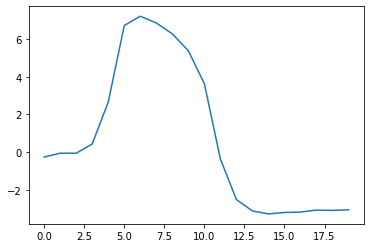

In [54]:
plt.plot(prediction_10[880:900])

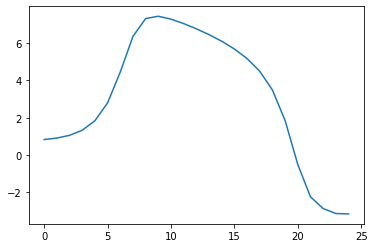

In [60]:
plt.plot(test_norm[905:930])

In [42]:
prediction_10[470:485]

[-0.7522201538085938,
 -0.7547845840454102,
 -0.6951100826263428,
 -0.44294700026512146,
 2.384648561477661,
 7.087745666503906,
 7.1655426025390625,
 6.637434005737305,
 6.0550103187561035,
 5.043349266052246,
 2.950018882751465,
 -0.9200977087020874,
 -2.6937031745910645,
 -3.1502058506011963,
 -3.2601430416107178]

In [64]:
model.eval()
model.to('cpu')
rmse = []

k = 15
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        x = torch.reshape(torch.FloatTensor(loop_steps).view(-1), (1, 20, 1)).to('cpu')
        y_pred = model(x)
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

r = (((np.array(prediction[:-k+1])*std+mean - np.array(test[20+k-1:]))**2).mean())**0.5
r

0.148427940457489

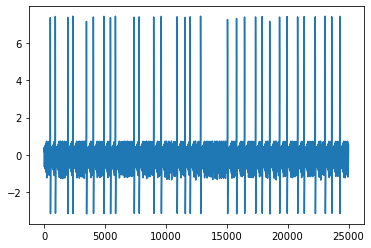

In [66]:
plt.plot(test_norm)

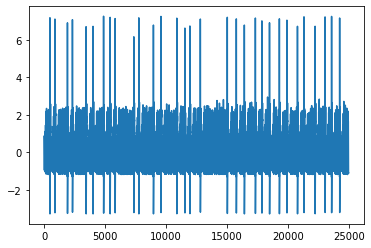

In [65]:
plt.plot(prediction)

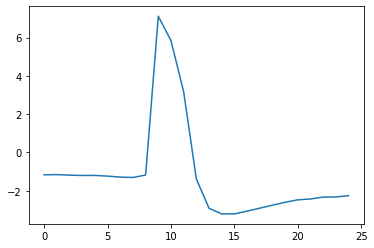

In [70]:
plt.plot(prediction[875:900])

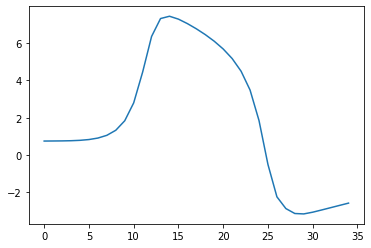

In [71]:
plt.plot(test_norm[900:935])

In [75]:
torch.tensor(prediction[865:900])

tensor([-0.6983, -0.8837, -1.0171, -1.0686, -1.1295, -1.1527, -1.1620, -1.1549,
        -1.1497, -1.1484, -1.1665, -1.1572, -1.1843, -1.2011, -1.1985, -1.2362,
        -1.2873, -1.3077, -1.1781,  7.1103,  5.8352,  3.1633, -1.3812, -2.9151,
        -3.2089, -3.2071, -3.0654, -2.9091, -2.7525, -2.6038, -2.4721, -2.4293,
        -2.3312, -2.3228, -2.2590])

In [74]:
test_norm[890:935]

tensor([ 0.4708,  0.5239,  0.5718,  0.6141,  0.6506,  0.6810,  0.7055,  0.7241,
         0.7373,  0.7459,  0.7511,  0.7546,  0.7592,  0.7689,  0.7897,  0.8315,
         0.9108,  1.0575,  1.3286,  1.8372,  2.7952,  4.4443,  6.3534,  7.3108,
         7.4343,  7.2790,  7.0399,  6.7617,  6.4497,  6.0956,  5.6807,  5.1689,
         4.4878,  3.4823,  1.8482, -0.5060, -2.2360, -2.8646, -3.1290, -3.1509,
        -3.0583, -2.9396, -2.8169, -2.6944, -2.5728])

In [77]:
test_norm[test_norm > 0.65].shape

torch.Size([2226])